# Build some toy models and how to sample them

## Roadmap

- Step through training loop, line by line
- Run small training run!

In [2]:
# use autoreload
%load_ext autoreload
%autoreload 2

import yaml
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

# import lightning trainer
import lightning as L
from lightning.pytorch.loggers import WandbLogger

# imports
from jepa.modules import TrueContrastiveLearning

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/traitlets/con

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/traitlets/con

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

## Explore Model Loading

In [2]:
with open("configs/4_testing.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
model = TrueContrastiveLearning(**config)

## Training Step

In [57]:
for batch in model.train_dataloader():
    x, mask, pids, events_df = batch
    print(x.shape, mask.shape)

    context_mask, target_mask, inner_target_flag = model.sample_context(x, mask)
    # print(context_mask.shape, target_mask.shape)

    break

torch.Size([100, 16, 2]) torch.Size([100, 16])


In [26]:
pids

tensor([[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]])

In [27]:
x

tensor([[[-0.1900,  0.4625],
         [-0.3788,  0.7689],
         [-1.5538,  1.6764],
         [-0.6276, -2.5673],
         [-0.7204, -2.1692],
         [-0.7177, -1.3980],
         [-0.3220, -0.3825],
         [-0.5001, -0.6961],
         [-0.6112,  1.0492],
         [-0.4625, -2.9641],
         [-1.2006,  1.5093],
         [-2.3654,  1.8453],
         [-0.6334, -1.0360],
         [-0.7484, -1.7774],
         [-0.8858,  1.2980],
         [-1.9430,  1.7915]]])

In [28]:
context_mask

tensor([[False, False,  True,  True,  True, False, False, False, False,  True,
          True,  True, False,  True, False,  True]])

In [29]:
target_mask

tensor([[ True,  True, False, False, False,  True,  True,  True,  True, False,
         False, False,  True, False,  True, False]])

In [62]:
seeds = []
batchlevel_pids = []
batch_indices = []

max_pid = 0

for batch_idx in tqdm(range(mask.shape[0])):
    batch_max_pid = 0
    for pid in pids[batch_idx][mask[batch_idx]].unique():
        for mask_type in [context_mask, target_mask]:
            seed = x[batch_idx][mask_type[batch_idx]][pids[batch_idx][mask_type[batch_idx]] == pid]
            seed = seed.view(-1)
            if seed.shape[0] == 8:
                seeds.append(seed)
                batchlevel_pid = pid.item() + max_pid  # Add max_pid to make it unique across batches
                batchlevel_pids.append(batchlevel_pid)
                batch_indices.append(batch_idx)
                batch_max_pid = max(batch_max_pid, batchlevel_pid)
    
    max_pid = batch_max_pid + 1  # Update max_pid for the next batch

seeds = torch.stack(seeds)
batch_indices = torch.tensor(batch_indices)
batchlevel_pids = torch.tensor(batchlevel_pids)

100%|██████████| 100/100 [00:00<00:00, 4836.33it/s]


In [87]:
import torch

def create_batch_edges_fixed(batch_indices, entries_per_batch=4):
    total_entries = batch_indices.max().item() + 1  # Number of unique batch indices
    num_batches = total_entries

    # Create base indices for each batch
    batch_base = torch.arange(0, num_batches * entries_per_batch, entries_per_batch).unsqueeze(1)
    
    # Create offsets for connections within a batch
    offsets = torch.tensor([(i, j) for i in range(entries_per_batch) for j in range(i+1, entries_per_batch)])
    
    print("batch_base shape:", batch_base.shape)
    print("offsets shape:", offsets.shape)

    # Repeat batch_base for each offset and reshape
    expanded_base = batch_base.repeat(1, offsets.shape[0]).view(-1, 1)
    
    # Repeat offsets for each batch
    repeated_offsets = offsets.repeat(num_batches, 1)
    
    # Create edges by adding expanded_base to both columns of repeated_offsets
    edges = expanded_base + repeated_offsets

    # Transpose to get 2xN shape
    edges = edges.t()

    return edges

# Create the edges
edges = create_batch_edges_fixed(batch_indices, entries_per_batch=4)

# Print the first few edges to verify
print(edges[:, :20])

# Print the shape to see total number of edges
print(f"Total edges: {edges.shape[1]}")

batch_base shape: torch.Size([100, 1])
offsets shape: torch.Size([6, 2])
tensor([[ 0,  0,  0,  1,  1,  2,  4,  4,  4,  5,  5,  6,  8,  8,  8,  9,  9, 10,
         12, 12],
        [ 1,  2,  3,  2,  3,  3,  5,  6,  7,  6,  7,  7,  9, 10, 11, 10, 11, 11,
         13, 14]])
Total edges: 600


In [89]:
edges.shape

torch.Size([2, 600])

In [82]:
# Unflatten seeds to [..., 2]
seeds = seeds.view(-1, 4, 2)

torch.Size([2, 600, 4, 2])

In [85]:
seeds[edges].shape

torch.Size([2, 600, 4, 2])

In [ ]:
# Get the first event

In [78]:
seeds.shape

torch.Size([400, 8])

In [ ]:
pids[edges]

## Train Run

In [5]:
with open("configs/4_testing.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [6]:
model = TrueContrastiveLearning(**config)

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/homes/d/danieltm/.conda/envs/jepa/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type | Params
-----------------------------------
0 | embedding | MLP  | 35.2 K
-----------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

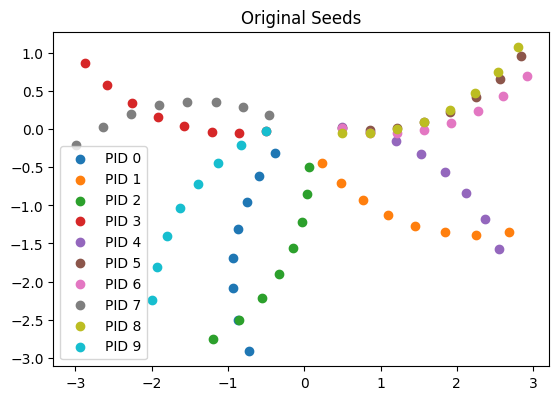

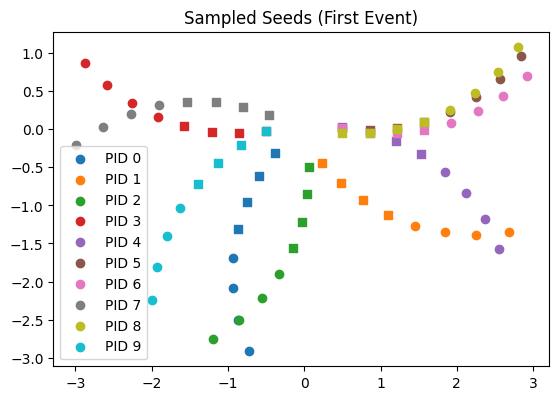

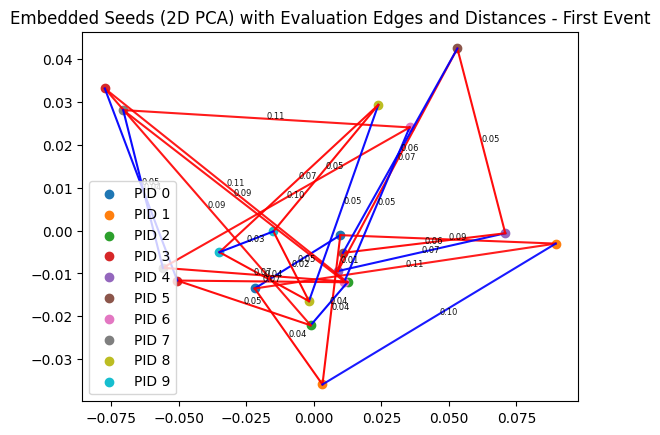

First Event Metrics:
  True positives: 10
  False positives: 20
  False negatives: 0
  Efficiency: 1.0000
  Purity: 0.3333
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:02<00:02,  0.39it/s]

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 200. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|██████████| 200/200 [02:57<00:00,  1.13it/s, v_num=zmjg]     

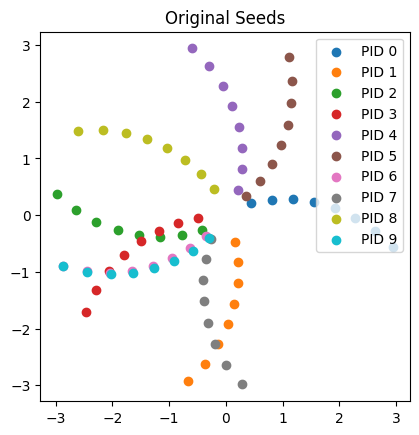

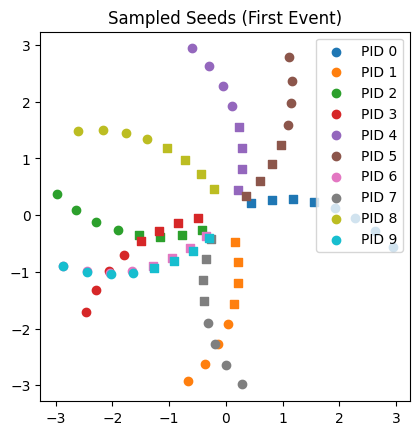

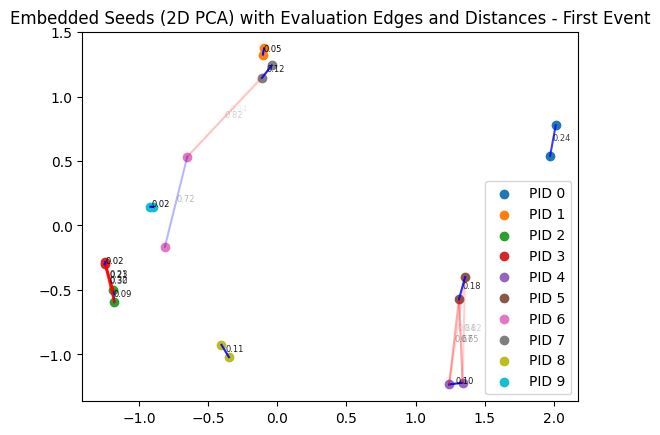

First Event Metrics:
  True positives: 10
  False positives: 10
  False negatives: 0
  Efficiency: 1.0000
  Purity: 0.5000
Epoch 1: 100%|██████████| 200/200 [03:06<00:00,  1.07it/s, v_num=zmjg]

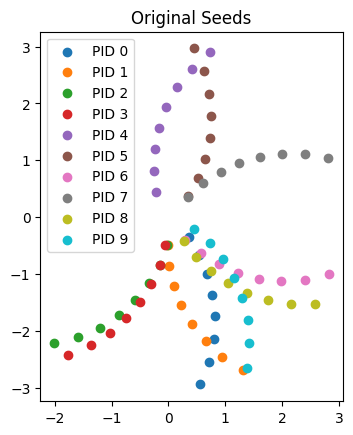

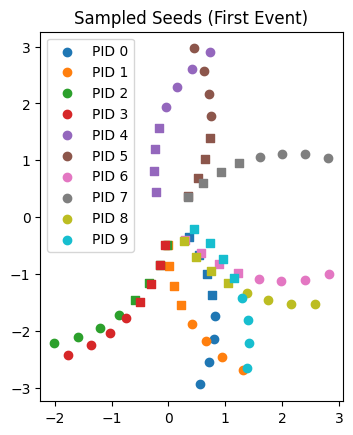

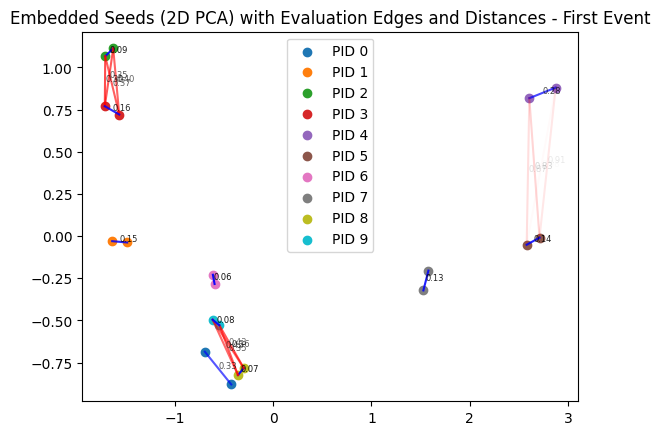

First Event Metrics:
  True positives: 10
  False positives: 12
  False negatives: 0
  Efficiency: 1.0000
  Purity: 0.4545
Epoch 2: 100%|██████████| 200/200 [03:09<00:00,  1.06it/s, v_num=zmjg]

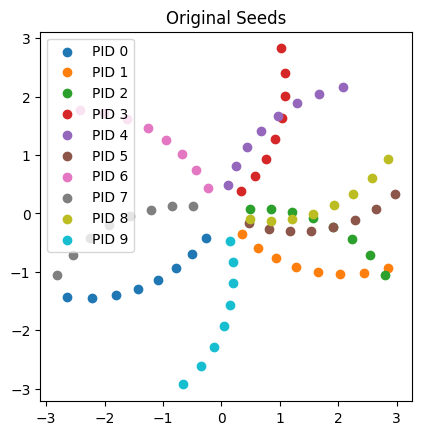

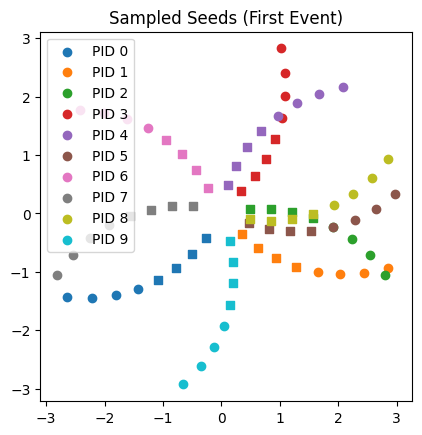

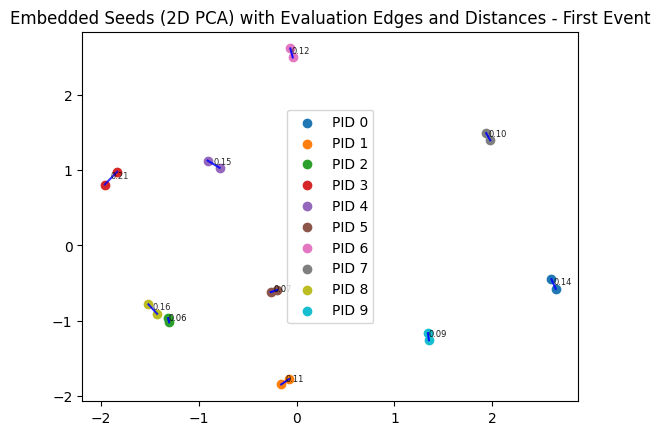

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 3: 100%|██████████| 200/200 [03:15<00:00,  1.02it/s, v_num=zmjg]

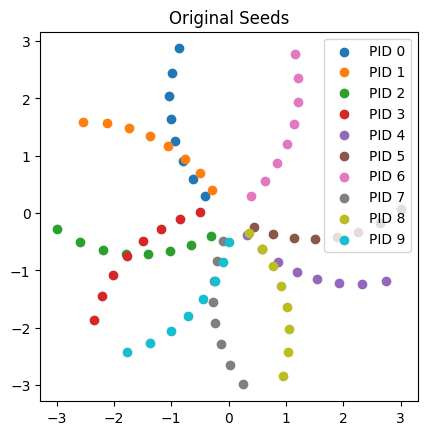

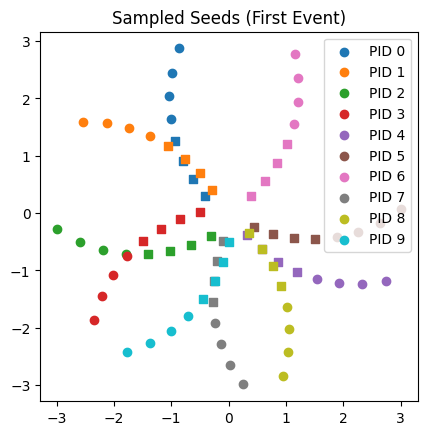

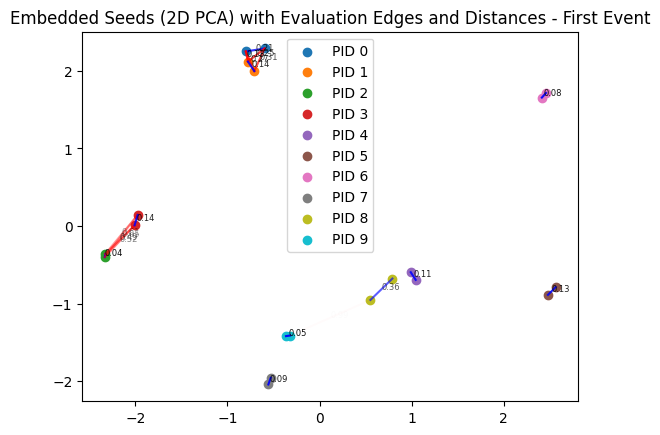

First Event Metrics:
  True positives: 10
  False positives: 9
  False negatives: 0
  Efficiency: 1.0000
  Purity: 0.5263
Epoch 4: 100%|██████████| 200/200 [03:04<00:00,  1.09it/s, v_num=zmjg]

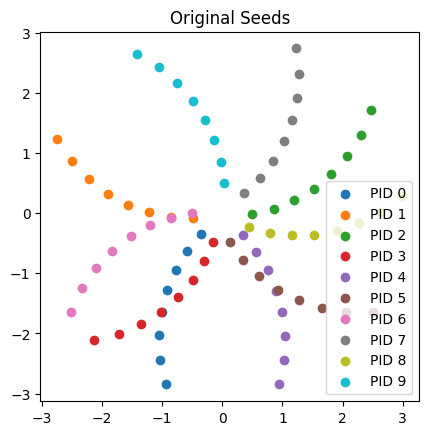

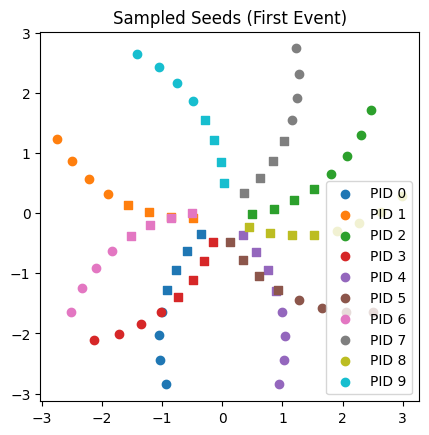

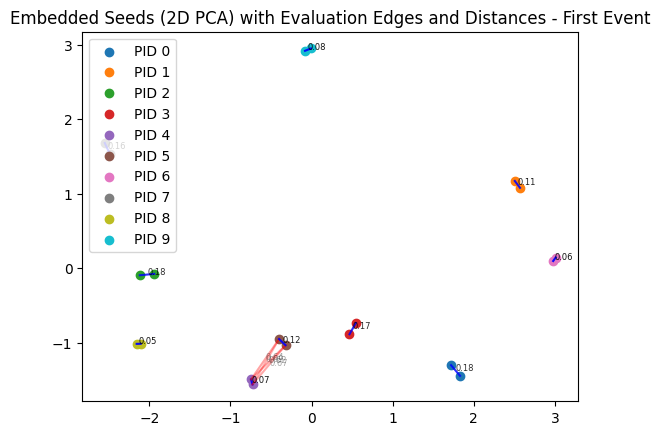

First Event Metrics:
  True positives: 10
  False positives: 4
  False negatives: 0
  Efficiency: 1.0000
  Purity: 0.7143
Epoch 5: 100%|██████████| 200/200 [02:59<00:00,  1.11it/s, v_num=zmjg]

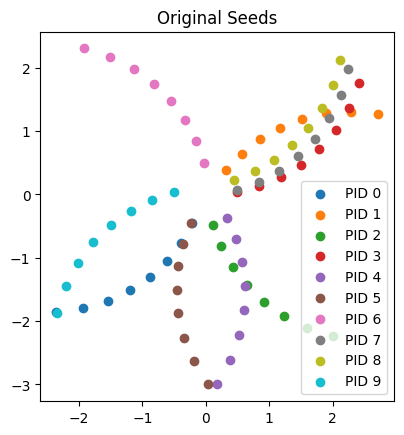

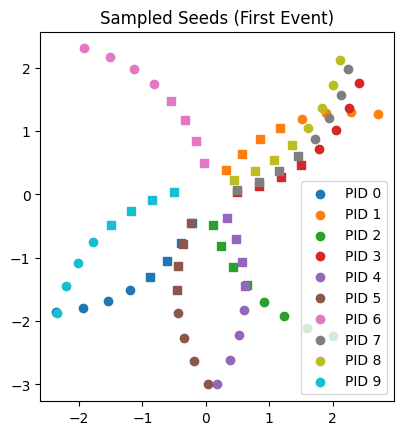

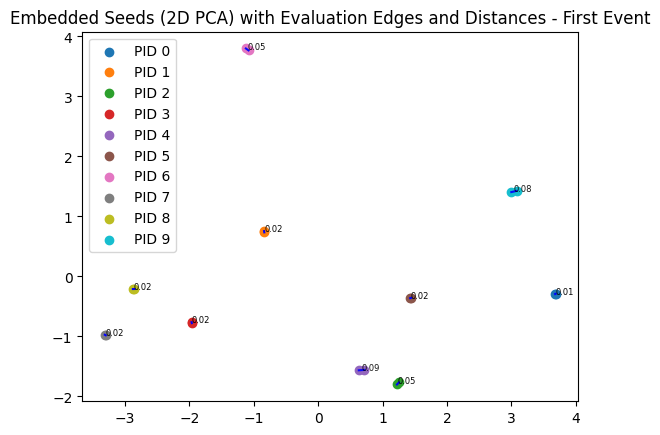

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 6: 100%|██████████| 200/200 [03:05<00:00,  1.08it/s, v_num=zmjg]

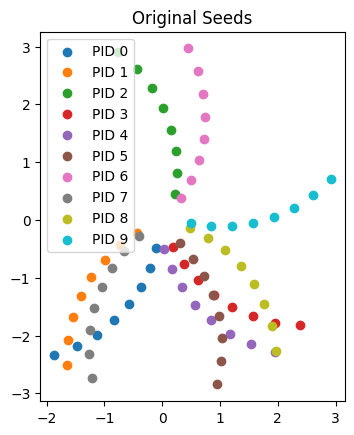

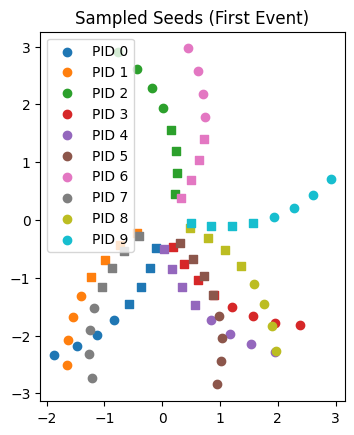

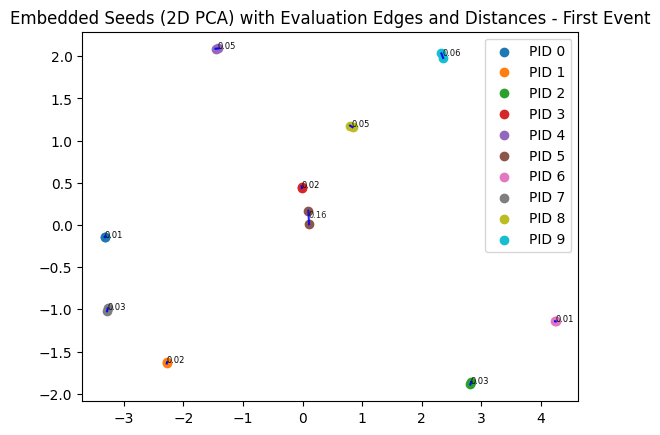

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 7: 100%|██████████| 200/200 [03:05<00:00,  1.08it/s, v_num=zmjg]

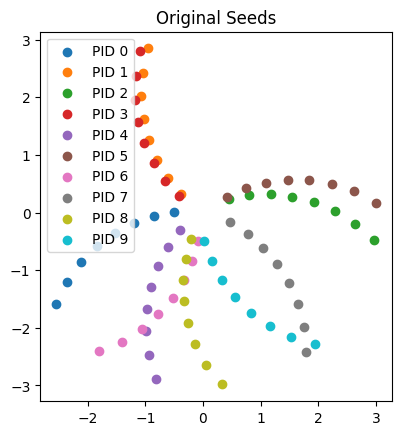

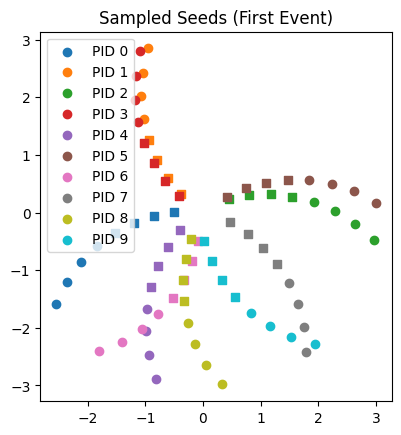

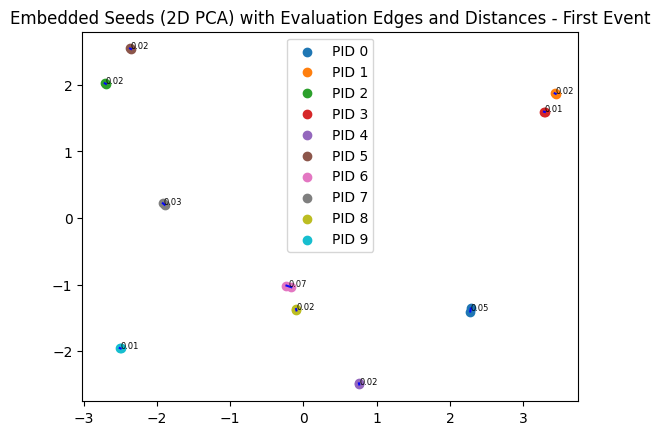

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 8: 100%|██████████| 200/200 [03:02<00:00,  1.09it/s, v_num=zmjg]

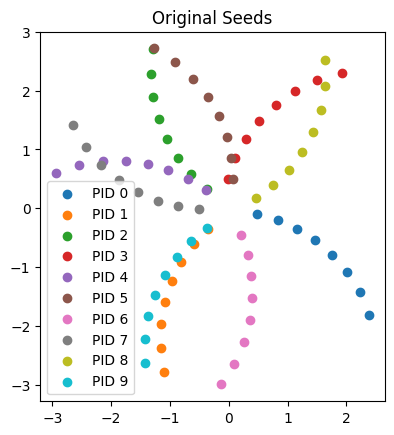

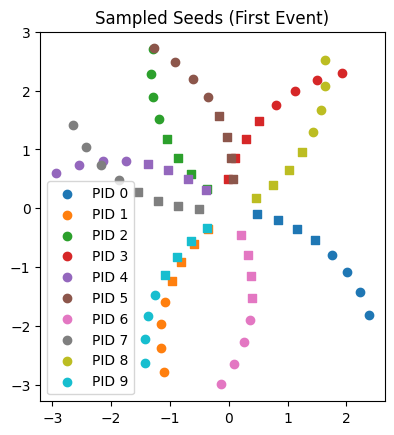

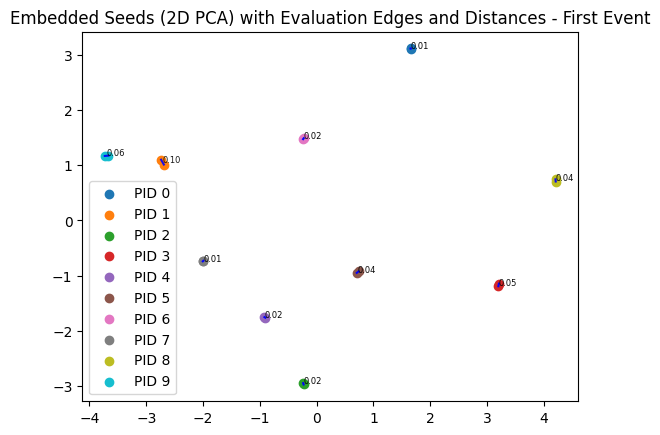

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 9: 100%|██████████| 200/200 [03:01<00:00,  1.10it/s, v_num=zmjg]

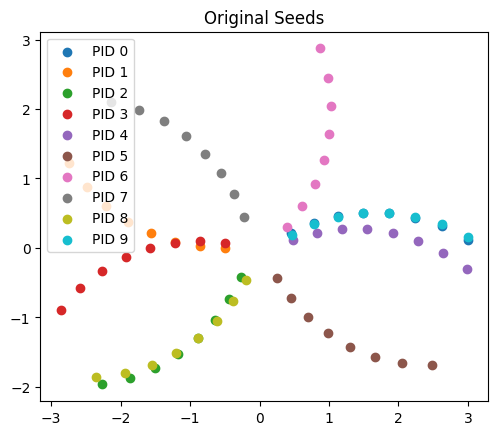

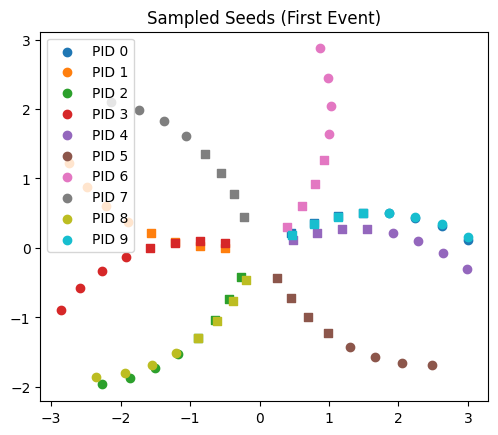

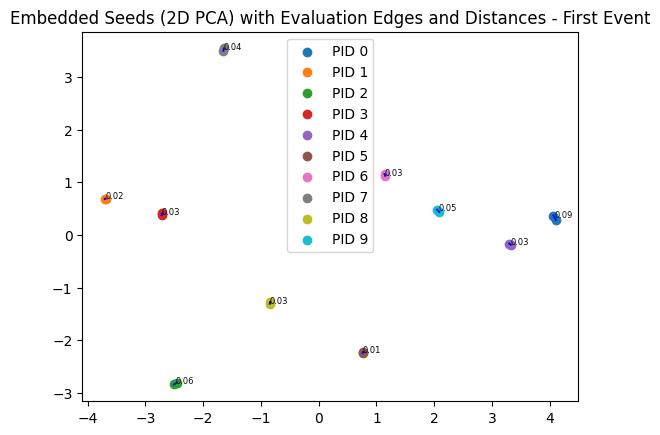

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 10: 100%|██████████| 200/200 [02:58<00:00,  1.12it/s, v_num=zmjg]

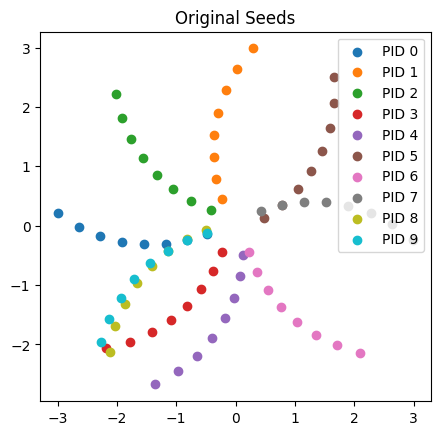

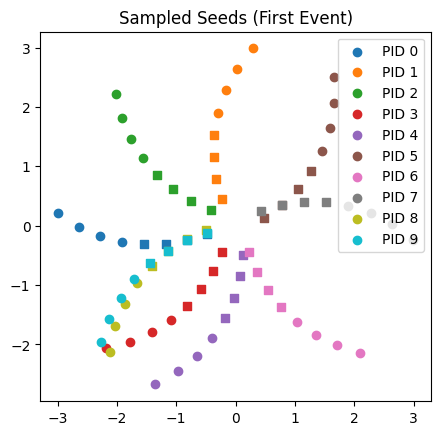

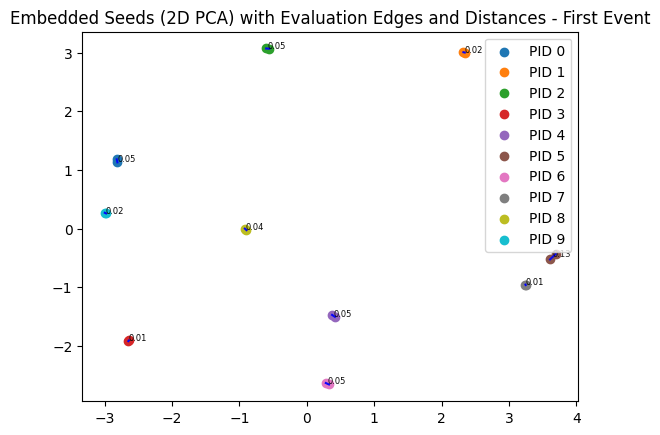

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 11: 100%|██████████| 200/200 [02:57<00:00,  1.12it/s, v_num=zmjg]

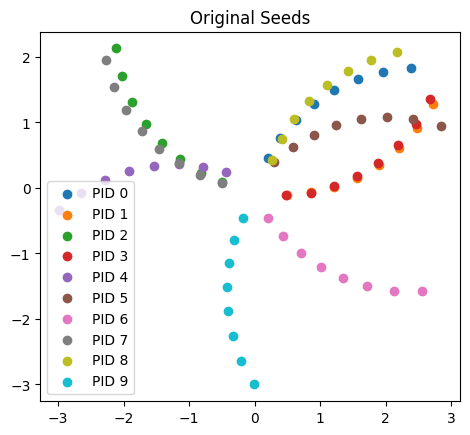

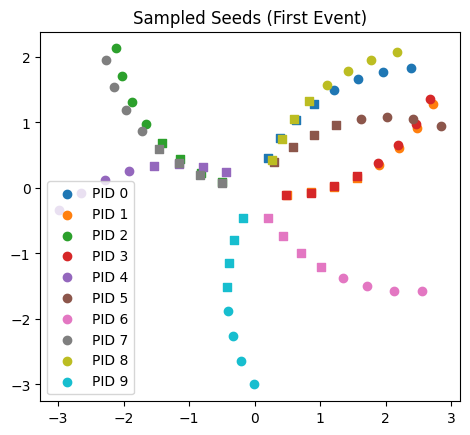

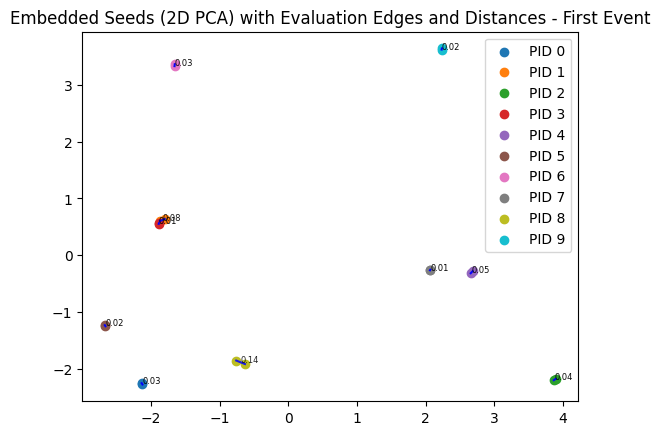

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 12: 100%|██████████| 200/200 [03:03<00:00,  1.09it/s, v_num=zmjg]

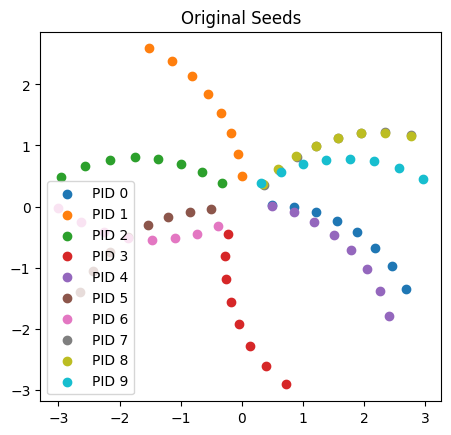

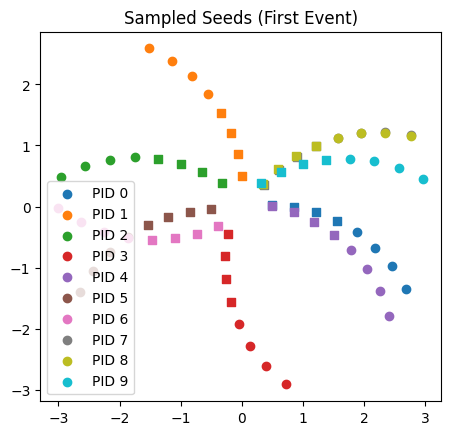

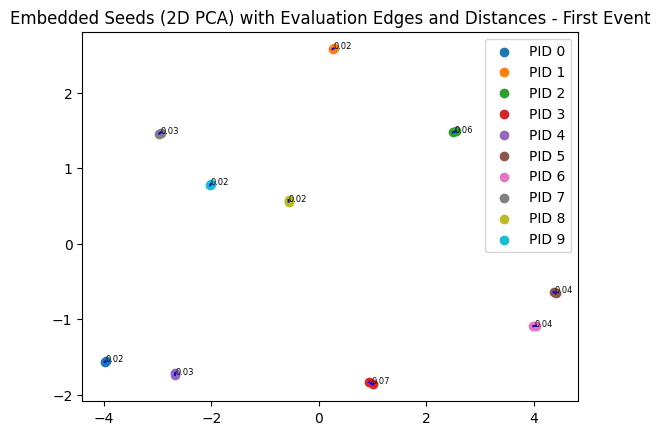

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 13: 100%|██████████| 200/200 [03:01<00:00,  1.10it/s, v_num=zmjg]

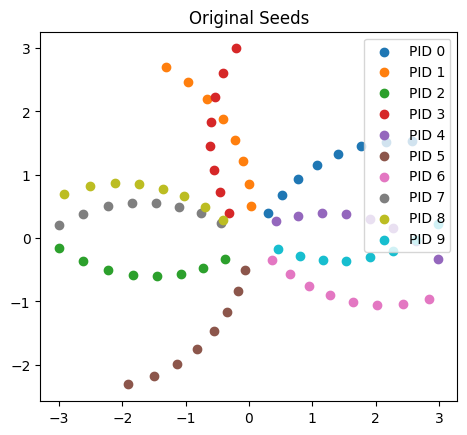

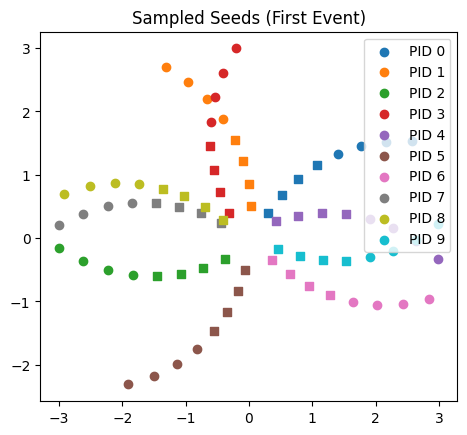

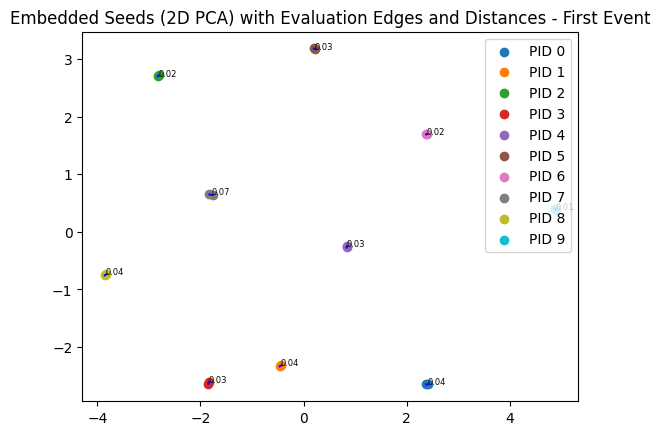

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 14: 100%|██████████| 200/200 [03:02<00:00,  1.10it/s, v_num=zmjg]

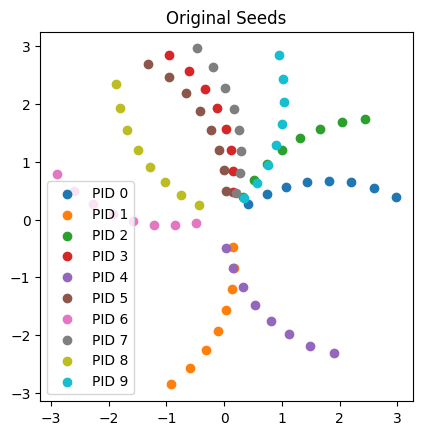

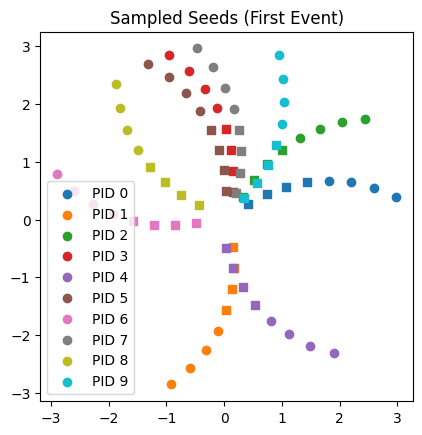

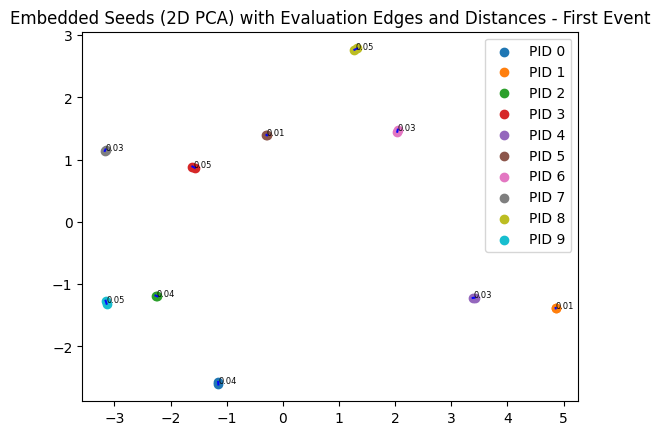

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 15: 100%|██████████| 200/200 [03:01<00:00,  1.10it/s, v_num=zmjg]

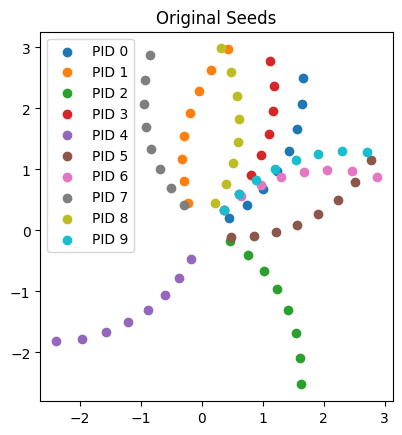

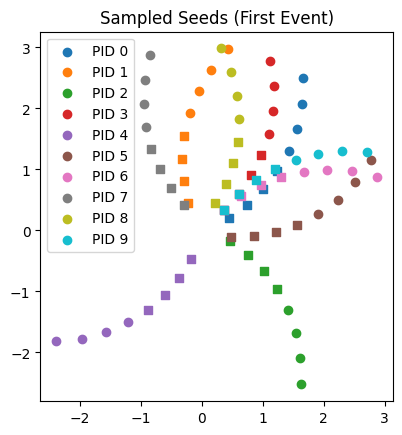

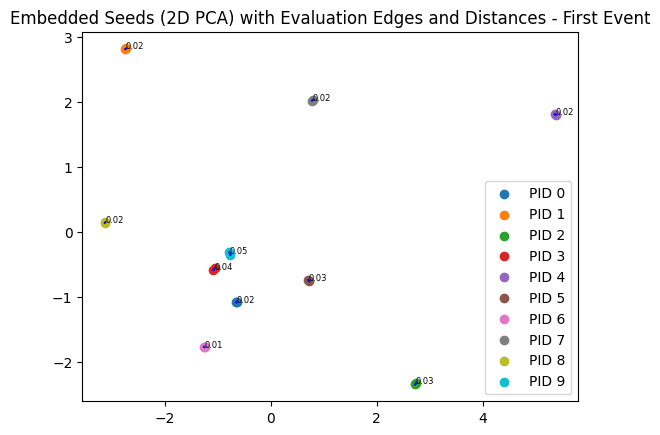

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 16: 100%|██████████| 200/200 [03:04<00:00,  1.08it/s, v_num=zmjg]

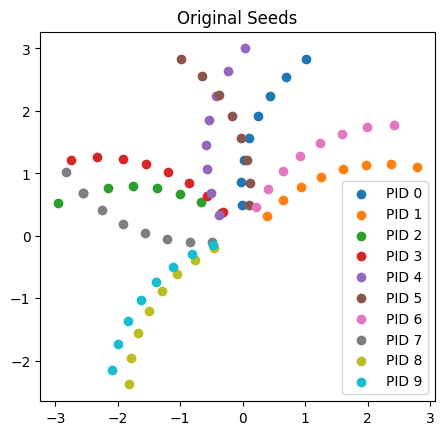

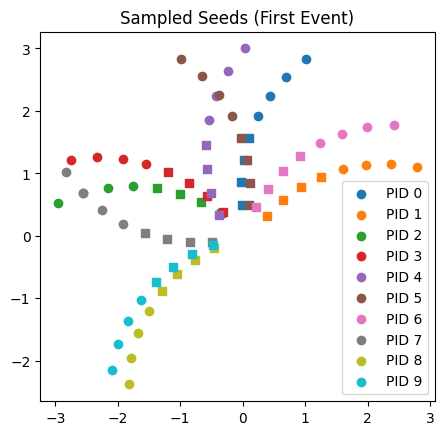

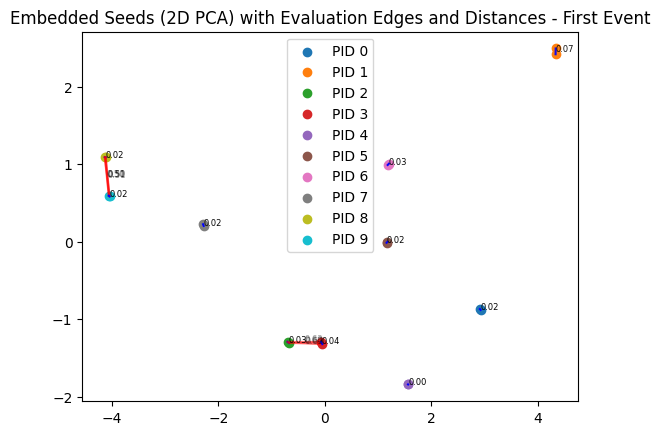

First Event Metrics:
  True positives: 10
  False positives: 8
  False negatives: 0
  Efficiency: 1.0000
  Purity: 0.5556
Epoch 17: 100%|██████████| 200/200 [03:03<00:00,  1.09it/s, v_num=zmjg]

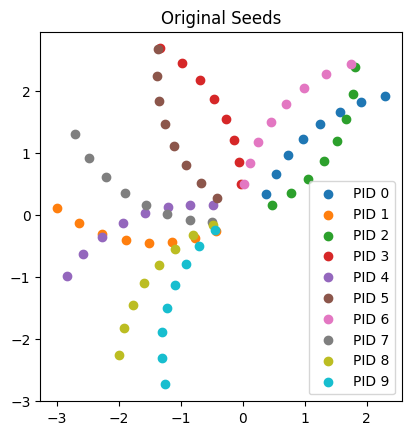

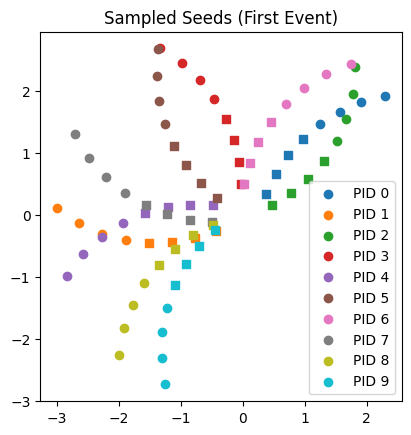

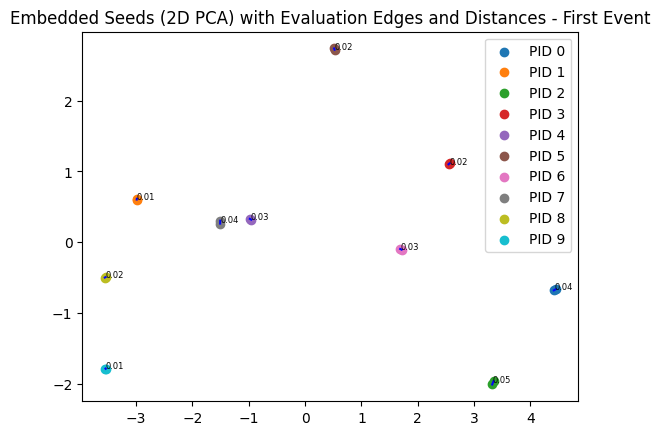

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 18: 100%|██████████| 200/200 [03:11<00:00,  1.05it/s, v_num=zmjg]

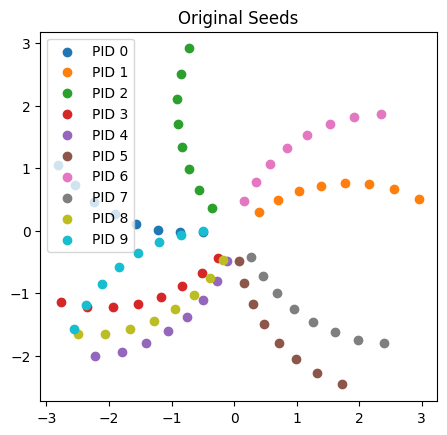

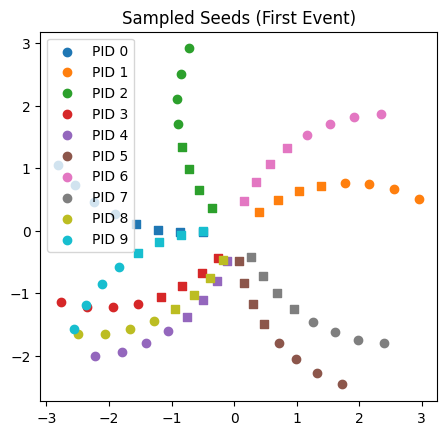

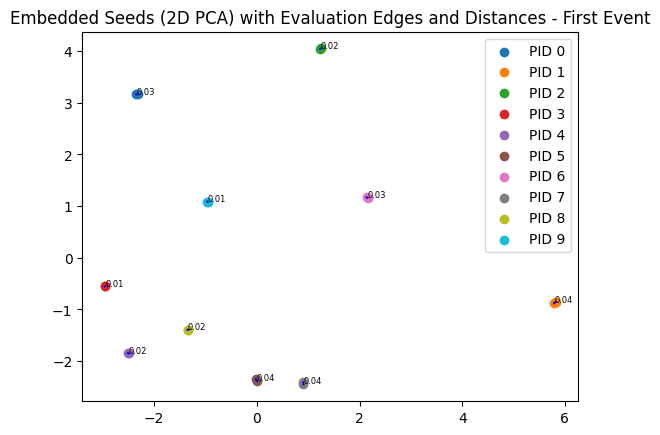

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 19: 100%|██████████| 200/200 [03:07<00:00,  1.07it/s, v_num=zmjg]

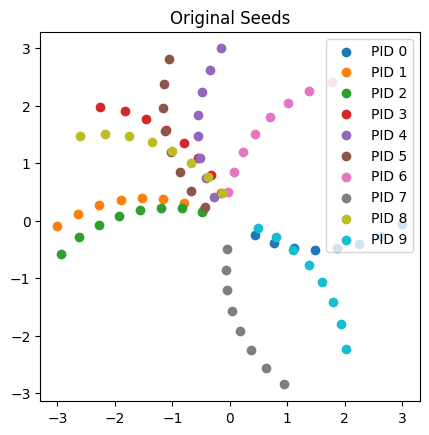

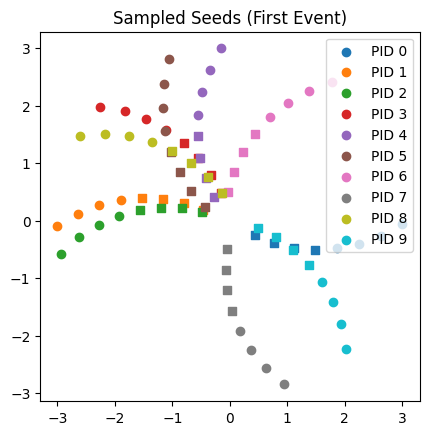

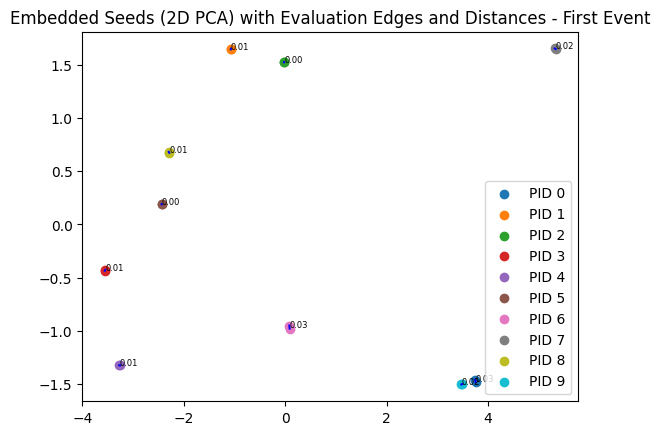

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 20: 100%|██████████| 200/200 [03:00<00:00,  1.11it/s, v_num=zmjg]

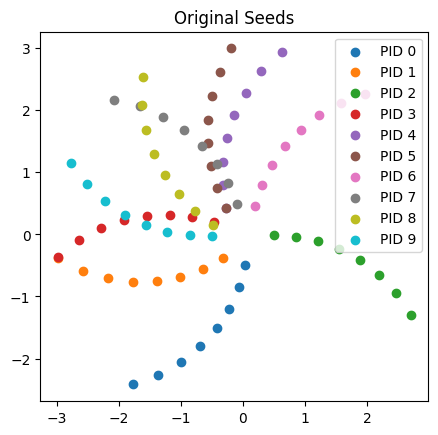

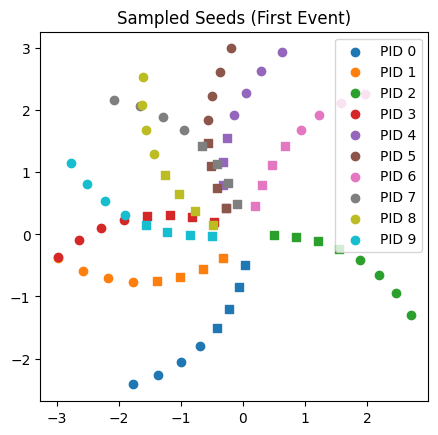

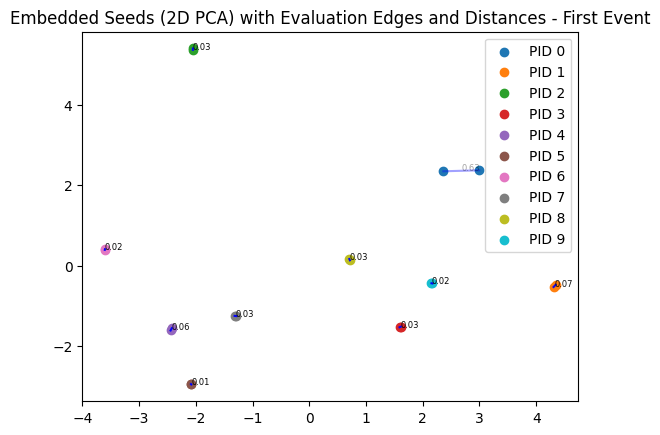

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 21: 100%|██████████| 200/200 [03:11<00:00,  1.05it/s, v_num=zmjg]

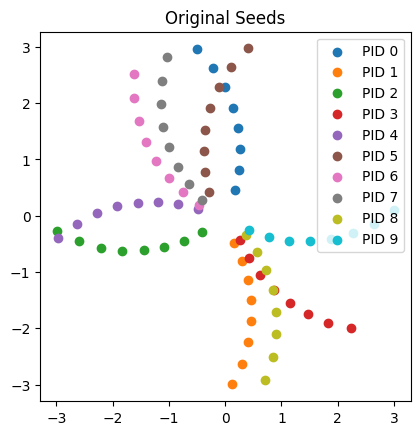

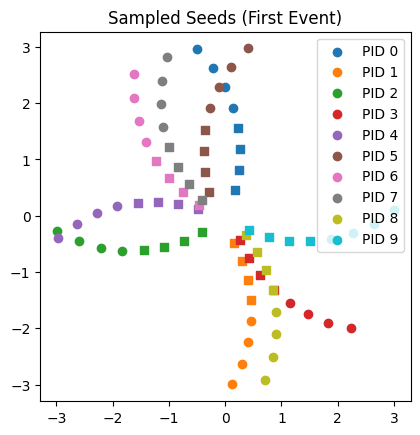

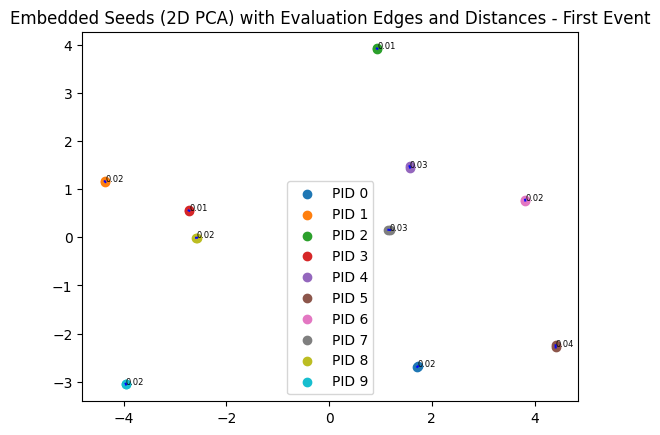

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 22: 100%|██████████| 200/200 [03:11<00:00,  1.05it/s, v_num=zmjg]

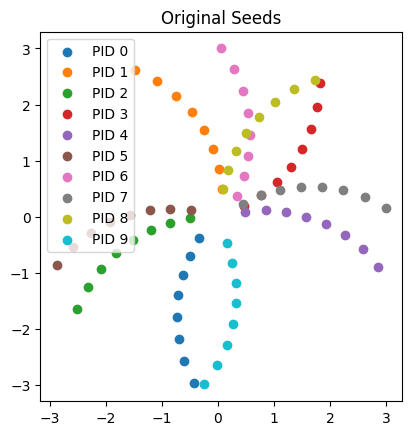

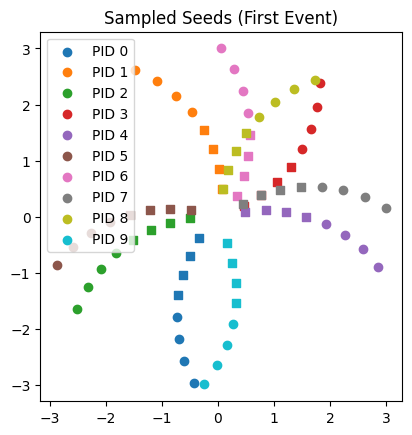

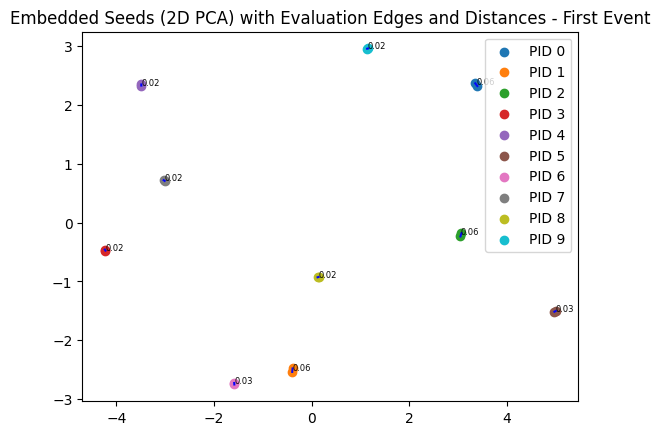

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 23: 100%|██████████| 200/200 [03:04<00:00,  1.08it/s, v_num=zmjg]

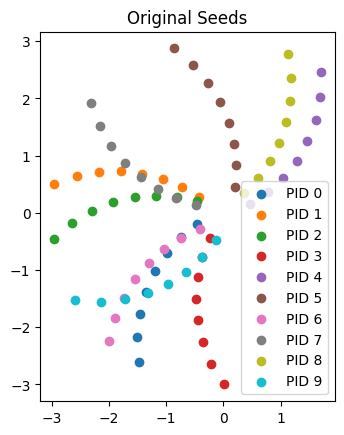

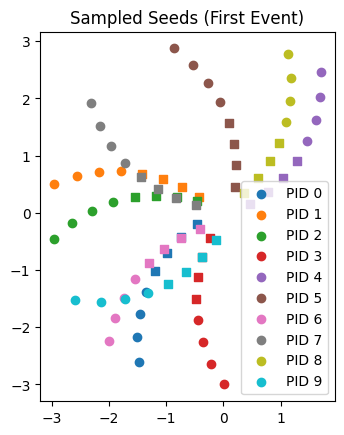

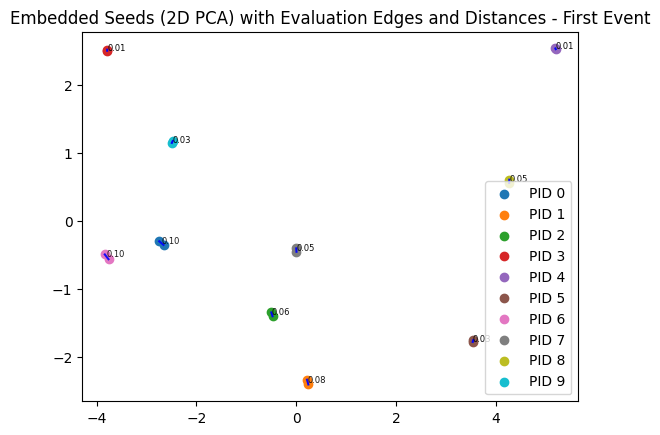

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 24: 100%|██████████| 200/200 [03:01<00:00,  1.10it/s, v_num=zmjg]

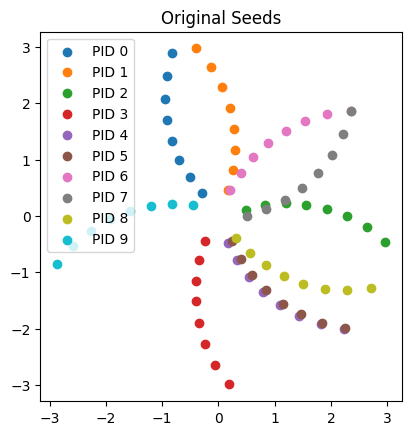

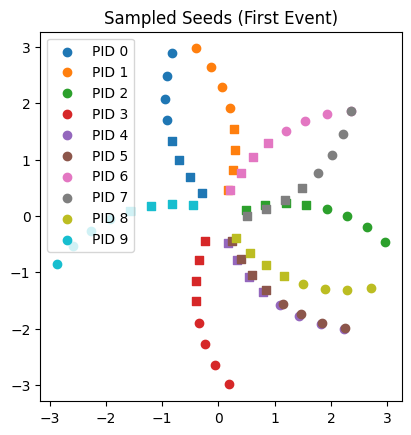

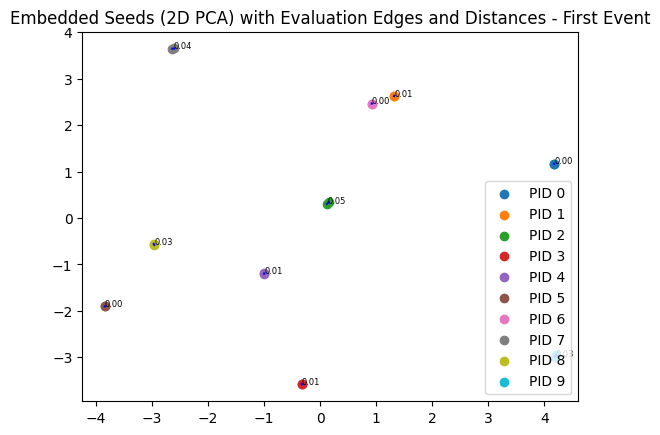

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 25: 100%|██████████| 200/200 [02:58<00:00,  1.12it/s, v_num=zmjg]

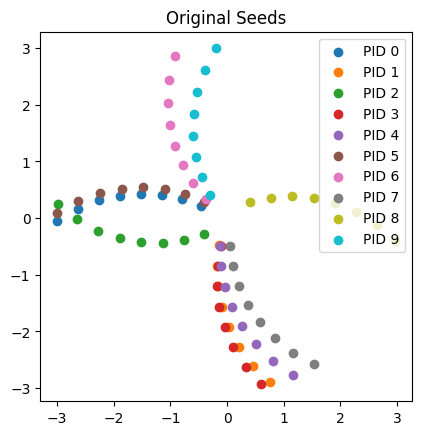

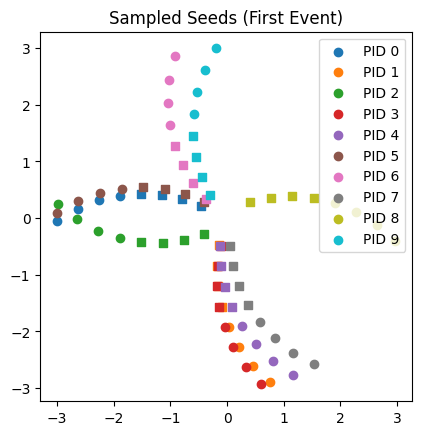

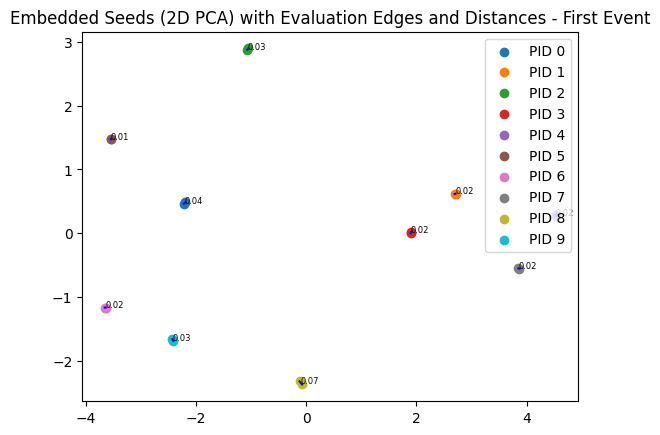

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 26: 100%|██████████| 200/200 [02:59<00:00,  1.12it/s, v_num=zmjg]

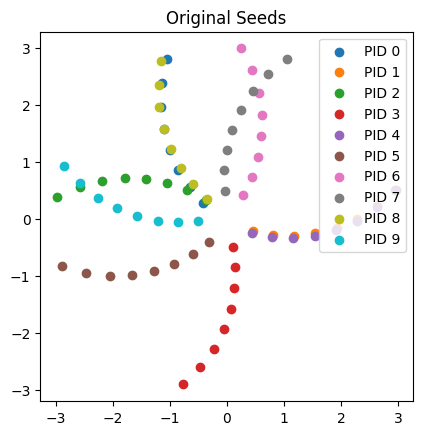

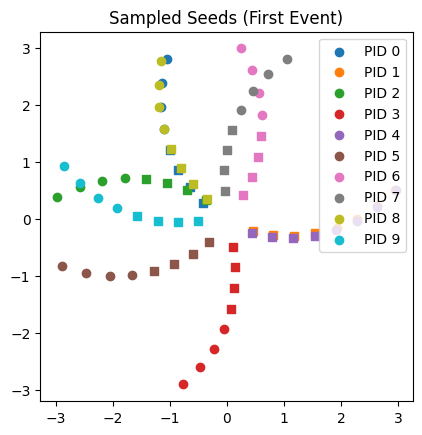

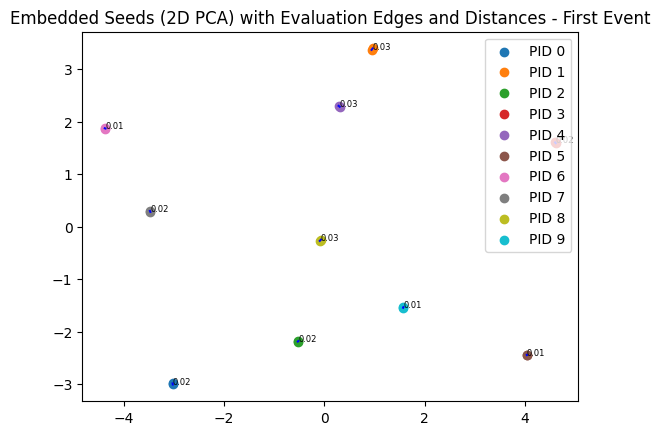

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 27: 100%|██████████| 200/200 [03:01<00:00,  1.10it/s, v_num=zmjg]

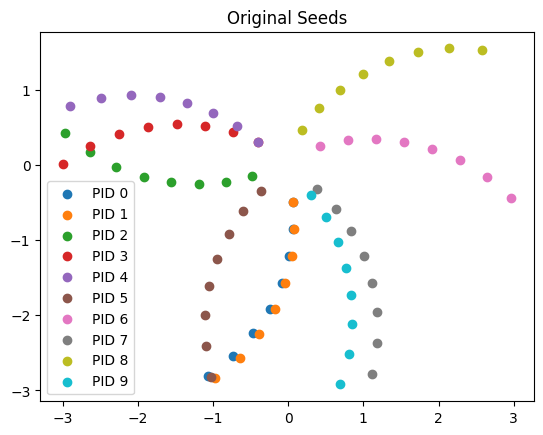

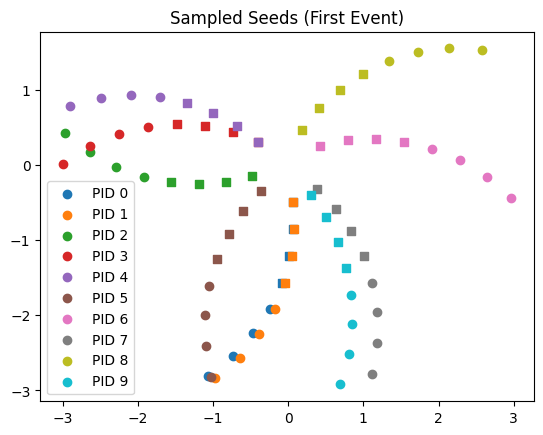

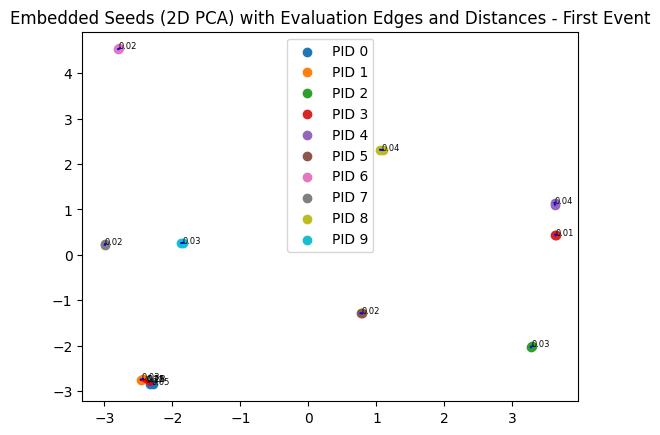

First Event Metrics:
  True positives: 10
  False positives: 4
  False negatives: 0
  Efficiency: 1.0000
  Purity: 0.7143
Epoch 28: 100%|██████████| 200/200 [03:04<00:00,  1.08it/s, v_num=zmjg]

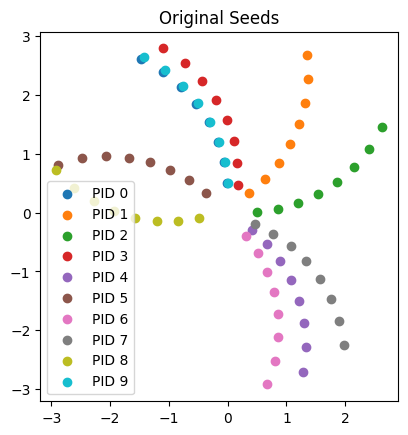

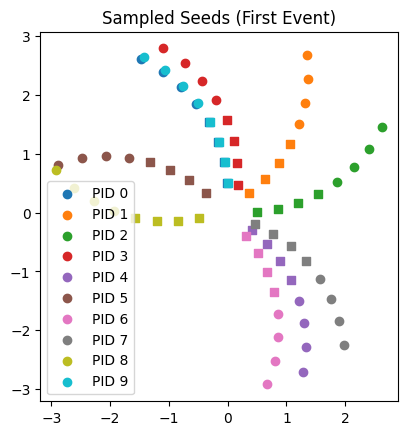

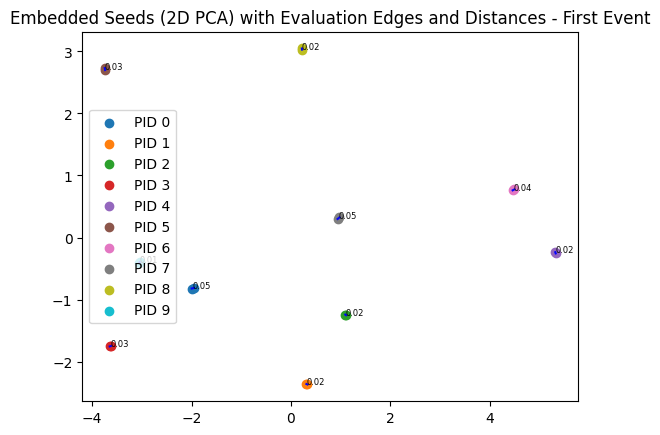

First Event Metrics:
  True positives: 10
  False positives: 0
  False negatives: 0
  Efficiency: 1.0000
  Purity: 1.0000
Epoch 29:  35%|███▌      | 70/200 [01:12<02:14,  0.97it/s, v_num=zmjg] 

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [7]:
wandb_logger = WandbLogger(project="JEPA_toytrack_splittracks_contrastive")
trainer = L.Trainer(
    max_epochs=50, 
    devices=1, 
    accelerator="gpu", 
    limit_train_batches = config["train_batches"], 
    limit_val_batches = config["val_batches"],
    logger = wandb_logger
)
trainer.fit(model=model)

## Visualize Source-Target Encodings

In [24]:
model = model.to("cpu")

In [25]:
# Loop through a 10 batches, append the source, target encodings
source_encodings = []
target_encodings = []

batches = 0

with torch.no_grad():
    for batch in model.train_dataloader():
        results = model.shared_evaluation(batch, 0)
        source_encodings.append(results["context"].detach())
        target_encodings.append(results["target"].detach())
        batches += 1
        if batches > 10:
            break


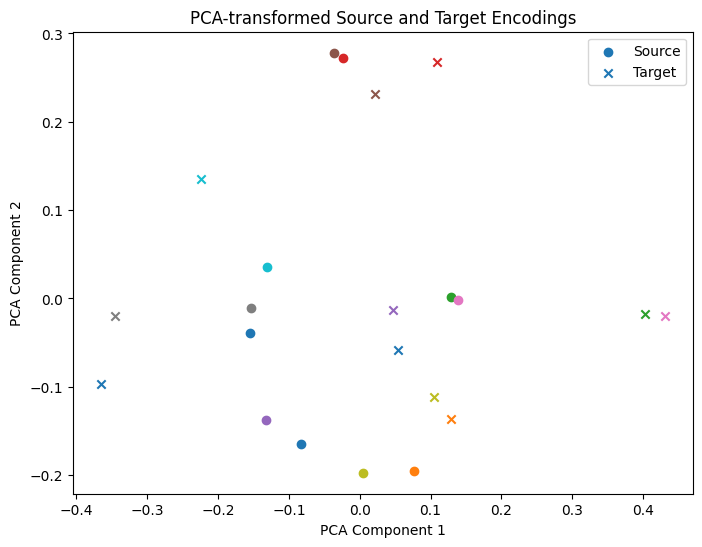

In [26]:
# Now PCA down the source and target encodings

# Sketch of changes:
# - Concatenate the source and target encodings into a single matrix
# - Perform PCA on the concatenated matrix to reduce dimensionality 
# - Extract the transformed source and target encodings from the PCA result
# - Visualize the PCA-transformed encodings in a scatter plot with matching colors for source and target encodings
# - Use 'o' for source encodings and 'x' for target encodings

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Concatenate source and target encodings
source_encodings_cat = np.concatenate([x.numpy() for x in source_encodings], axis=0)
target_encodings_cat = np.concatenate([x.numpy() for x in target_encodings], axis=0)
encodings_matrix = np.concatenate([source_encodings_cat, target_encodings_cat], axis=0)

# Perform PCA
pca = PCA(n_components=2)
pca_encodings = pca.fit_transform(encodings_matrix)

# Extract transformed source and target encodings
pca_source_encodings = pca_encodings[:len(source_encodings_cat)]
pca_target_encodings = pca_encodings[len(source_encodings_cat):]

# Visualize PCA-transformed encodings
plt.figure(figsize=(8, 6))
for i in range(len(pca_source_encodings)):
    plt.scatter(pca_source_encodings[i, 0], pca_source_encodings[i, 1], color=f'C{i}', marker='o', label='Source' if i == 0 else "")
    plt.scatter(pca_target_encodings[i, 0], pca_target_encodings[i, 1], color=f'C{i}', marker='x', label='Target' if i == 0 else "")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.title('PCA-transformed Source and Target Encodings')
plt.show()

In [27]:
# Loop through a 10 batches, append the source, target encodings
prediction_encodings = []
target_encodings = []

batches = 0

with torch.no_grad():
    for batch in model.train_dataloader():
        results = model.shared_evaluation(batch, 0)
        prediction_encodings.append(results["prediction"].detach())
        target_encodings.append(results["target"].detach())
        batches += 1
        if batches > 10:
            break


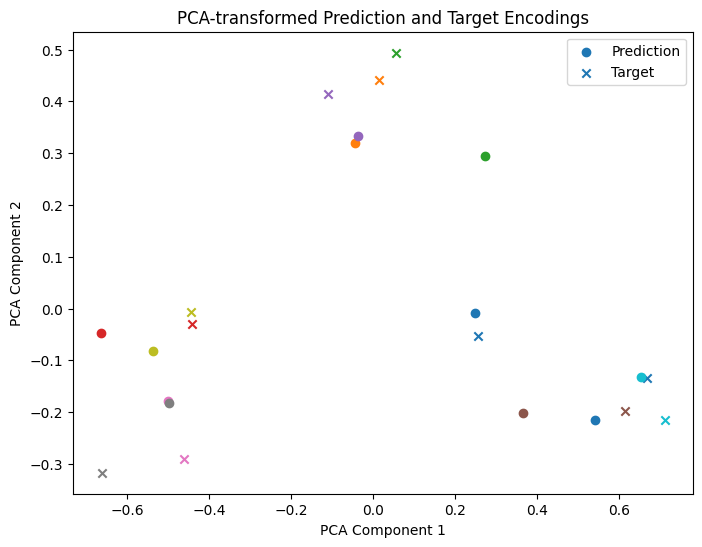

In [28]:
# Now PCA down the source and target encodings

# Sketch of changes:
# - Concatenate the source and target encodings into a single matrix
# - Perform PCA on the concatenated matrix to reduce dimensionality 
# - Extract the transformed source and target encodings from the PCA result
# - Visualize the PCA-transformed encodings in a scatter plot with matching colors for source and target encodings
# - Use 'o' for source encodings and 'x' for target encodings

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Concatenate source and target encodings
prediction_encodings_cat = np.concatenate([x.numpy() for x in prediction_encodings], axis=0)
target_encodings_cat = np.concatenate([x.numpy() for x in target_encodings], axis=0)
encodings_matrix = np.concatenate([prediction_encodings_cat, target_encodings_cat], axis=0)

# Perform PCA
pca = PCA(n_components=2)
pca_encodings = pca.fit_transform(encodings_matrix)

# Extract transformed source and target encodings
pca_prediction_encodings = pca_encodings[:len(prediction_encodings_cat)]
pca_target_encodings = pca_encodings[len(prediction_encodings_cat):]

# Visualize PCA-transformed encodings
plt.figure(figsize=(8, 6))
for i in range(len(pca_prediction_encodings)):
    plt.scatter(pca_prediction_encodings[i, 0], pca_prediction_encodings[i, 1], color=f'C{i}', marker='o', label='Prediction' if i == 0 else "")
    plt.scatter(pca_target_encodings[i, 0], pca_target_encodings[i, 1], color=f'C{i}', marker='x', label='Target' if i == 0 else "")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.title('PCA-transformed Prediction and Target Encodings')
plt.show()